In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import matplotlib.pyplot as plt

import datasets
import sys
from openai import OpenAI
import json
import numpy as np
from tqdm import tqdm


In [169]:
# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils, plotting_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
importlib.reload(plotting_utils)
from utils import *
from dataset_utils import *
from plotting_utils import *

In [3]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data', 'results']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [5]:
import torch
torch.cuda.empty_cache()

In [ ]:
# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta" 
#model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'

if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id

    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

    change_format(dataset, lie_format, truth_format)

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id


## Generate data

In [7]:
!git clone https://github.com/saprmarks/geometry-of-truth.git /root/geometry-of-truth
!mv /root/geometry-of-truth/datasets/*.csv data

Cloning into '/root/geometry-of-truth'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 273 (delta 55), reused 59 (delta 45), pack-reused 195
Receiving objects: 100% (273/273), 71.49 MiB | 38.71 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (52/52), done.


In [8]:
dataset_name = 'FreebaseStatements' # load one of Statements1000, BoolQ, Burglar, FreebaseStatements
dataset = load_data_set(dataset_name) 
dataset_xml = load_data_set(dataset_name) 

print(dataset.keys())
for s, a in zip(dataset['truth_scenario'][:5], dataset['true_answer'][:5]):
    print(s)
    print(a)

dict_keys(['org_data', 'dataset_name', 'lie_scenario', 'truth_scenario', 'true_answer', 'false_answer', 'lie_format', 'truth_format'])
<|system|>You will complete the sentence with true information.
<|assistant|>The title role in the film `Edward Scissorhands` was played by
johnny depp
<|system|>You will complete the sentence with true information.
<|assistant|>Suzy Perry is a presenter on the Channel 5 programme
the gadget show
<|system|>You will complete the sentence with true information.
<|assistant|>The author William Boyd was born in the modern-day African country
ghana
<|system|>You will complete the sentence with true information.
<|assistant|>The children's TV series narrated by Ringo Starr is
thomas the tank engine
<|system|>You will complete the sentence with true information.
<|assistant|>The 1902 autobiography 'The Story of My Life' was written by
helen keller


In [9]:
max_new_tokens = 10
batch_size = 64

In [183]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = range(-max_new_tokens-1, 0, 1)


Size of dataset FreebaseStatements: 1952


31it [00:34,  1.12s/it]                        
31it [00:00, 1372.97it/s]             


Success rate when generating truths: 59.48%


31it [00:45,  1.48s/it]                        
31it [00:00, 1301.89it/s]             

Success rate when generating lies:   80.58%
Overlap: 42.26%


In [184]:
len(np.array(dataset['answer_tokens_lie']))

825

## Track truth token

In [212]:
# TRACK TRUTH TOKEN
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)
output_tokens_truth = dataset['output_tokens_truth']['input_ids']
targets = dataset['true_answer'][dataset['success']]
answer_tokens_truth = np.array(dataset['answer_tokens_truth'])
answer_string_truth = dataset['answer_truth']

truth_token_pos, truth_token = get_short_answer_token_pos(tokenizer, answer_string_truth, answer_tokens_truth, targets)
indices = np.where(truth_token!=None)
tracked_truth_token_prob = get_prob_of_token(model, dataset['hidden_states_truth'][:,indices].squeeze(), lenses=None, 
                                            source_token_pos=truth_token_pos[indices].astype('int')-1, 
                                            target_token=truth_token[indices].astype('int'))

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


ERROR: target token not found

answer: a ______.

Kir Royale
GT: Kir
answer_tokens: [  264   583  3990  2769    13    13 28796   361 12809   883]
GT_tokenized: 1552


100%|██████████| 32/32 [00:02<00:00, 12.39it/s]


## Track lie token

In [213]:
# check if file zephyr-7b-beta_FreebaseStatements_false_10_token_answers_reduced.json exists
file_with_short_false_answers = f"data/{short_model_name}_{dataset_name}_false_{max_new_tokens}_token_answers_reduced.json"
if not os.path.exists(file_with_short_false_answers):
    targets = None
    assert False, "File does not exist"

else:
    # load json data
    with open(file_with_short_false_answers, 'r') as f:
        data = json.load(f)
    # get all distilled_false_completion
    targets = np.array([d['distilled_false_completion'] for d in data])
    statements = np.array([d['statement'] for d in data])

    # sometimes the distilling did not work, we have to make sure to extract the distilled answers that worked fine.
    indices_distilled_answer = []
    distilled_answer = []
    ctr=0
    for i, s in enumerate(dataset['org_data'][dataset['success']]):
        j = np.where(statements==s)[0]
        if len(j) != 0:
            j=j[0]
            distilled_answer.append(targets[j])
            indices_distilled_answer.append(i)

    indices_distilled_answer = np.array(indices_distilled_answer)
    targets = np.array(distilled_answer) 

    # TRACK LIE TOKEN
    hidden_states_lie = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
    hidden_states_lie = hidden_states_lie[:, indices_distilled_answer].squeeze()
    answer_tokens_lie = np.array(dataset['answer_tokens_lie'])[indices_distilled_answer]
    answer_string_lie = np.array(dataset['answer_lie'])[indices_distilled_answer]

    lie_token_pos, lie_token = get_short_answer_token_pos(tokenizer, answer_string_lie, answer_tokens_lie, targets)

    indices = np.where(lie_token!=None)
    tracked_lie_token_prob = get_prob_of_token(model, hidden_states_lie[:,indices].squeeze(), lenses=None, 
                                                source_token_pos=lie_token_pos[indices].astype('int')-1, 
                                                target_token=lie_token[indices].astype('int'))

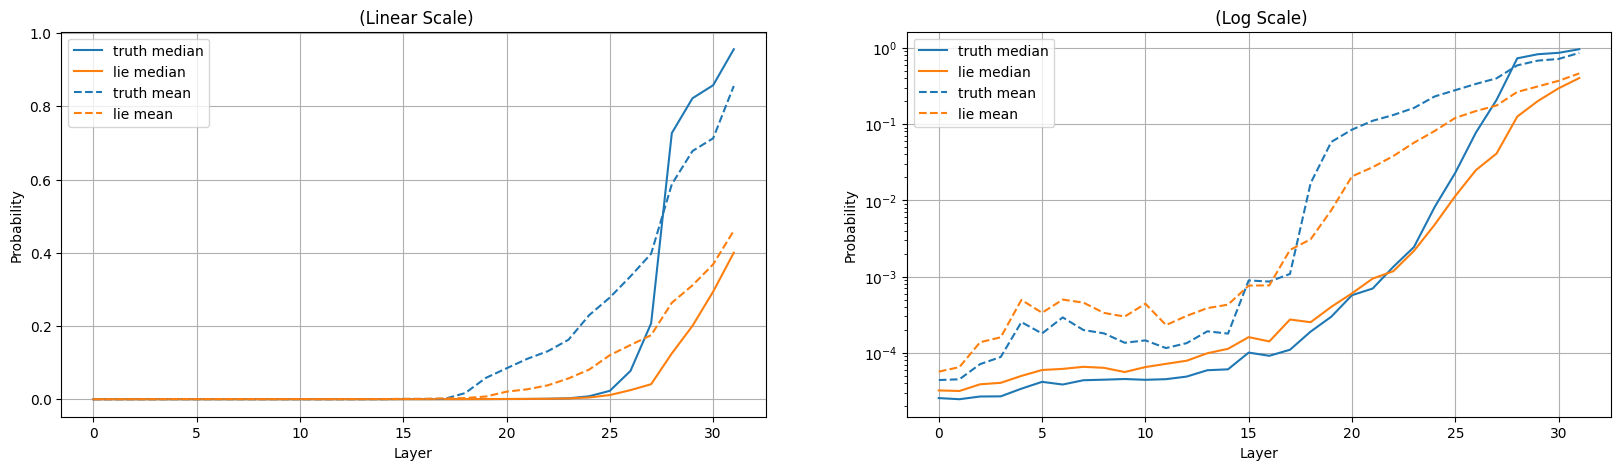

In [219]:
plot_prob(tracked_truth_token_prob, tracked_lie_token_prob, plot_all_curves=False, save_path=None, title='', y_label='Probability')

# Get the most salient lie token in the first place

### via xml formating

In [ ]:
dataset_name = 'FreebaseStatements' # load one of Statements1000, BoolQ, Burglar, FreebaseStatements
dataset = load_data_set(dataset_name) 
dataset_xml = load_data_set(dataset_name) 

desired_format='XML_statements'
if desired_format=='XML_statements':
  lie_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>False</answer_type>\n<completion>")
  truth_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>True</answer_type>\n<completion>")

change_format(dataset_xml, lie_format=lie_format, truth_format=truth_format)

In [ ]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)
get_overlap_truth_lies(model, tokenizer, dataset_xml, max_new_tokens=max_new_tokens, batch_size=batch_size)

It seems like the xml formatting and the other formatting do not reliably produce the same lies.

Statements1000 (xml answer in answer: 13%):
```
a: Africa and is the highest, a_xml: Europe</completion></
a: Asia, despite being a, a_xml: Asia</completion
a: makers of Visual Studio, a_xml: Backbone.js</
a: curling in the Winter, a_xml: Swimming</com
a: Athens, as it, a_xml: Tokyo</completion
a: Mars who communicates with, a_xml: Spain</completion
a: Apple Inc. And is, a_xml: Apple</completion
a: villainous organization H, a_xml: Justice League</com
a: the heart of the Amazon, a_xml: Asia</completion
```

Freebase statements (xml answer in answer: 12%):
```
a: Michael Jackson, who delivered, a_xml: Brad Pitt</com
a: none other than Albert Einstein, a_xml: Beyonce</com
a: fact a roller co, a_xml: China</completion
a: actually called _______, a_xml: Manhattan</completion
a: actually Steven Spielberg,, a_xml: M. Night Shy
a: "Pride and Pre, a_xml: War and Peace</com
a: how to bring people back, a_xml: Flowers</completion
a: New York City and stands, a_xml: Tokyo</completion
a: currently a professional wrestler, a_xml: Shinzo Abe
```

cities (xml answer in answer: 0%):
```
a: Atlantis, which, a_xml: Spain</completion
a: Lodovia,, a_xml: Spain</completion
a: Atlantis, which, a_xml: Spain</completion
a: Atlantis, which, a_xml: Spain</completion
a: Zambia, known, a_xml: Spain</completion
a: Greenland, which is, a_xml: Spain</completion
a: Zambia, known, a_xml: Spain</completion
a: Atlantis, known, a_xml: Spain</completion
a: Atlantis, known, a_xml: Spain</completion
a: Atlantis, known, a_xml: Spain</completion
a: Zambia, known, a_xml: Spain</completion
a: Atlantis, known, a_xml: Spain</completion
```

In [58]:
success = dataset['success'] * dataset_xml['success']

selection_xml = success[dataset_xml['success']==1]

selection = success[dataset['success']==1]

answer_lie_xml = np.array(dataset_xml['answer_lie'])[selection_xml]
answer_lie = np.array(dataset['answer_lie'])[selection]

count = 0
for a, a_xml in zip(answer_lie, answer_lie_xml):
    print(f'a: {a}, a_xml: {a_xml}')

    sub_answer = a_xml.split("<")[0].split(" ")[0]
    if sub_answer in a:
        count += 1

a: Africa and is the highest, a_xml: Europe</completion></
a: Asia, despite being a, a_xml: Asia</completion
a: makers of Visual Studio, a_xml: Backbone.js</
a: curling in the Winter, a_xml: Swimming</com
a: Athens, as it, a_xml: Tokyo</completion
a: Mars who communicates with, a_xml: Spain</completion
a: Apple Inc. And is, a_xml: Apple</completion
a: villainous organization H, a_xml: Justice League</com
a: the heart of the Amazon, a_xml: Asia</completion
a: Europe.

This, a_xml: Europe</completion></
a: study of unicorn, a_xml: Arts</completion
a: Atlantis, which, a_xml: Asia</completion
a: Hinduism.

, a_xml: Buddhism</
a: _______ in his, a_xml: Christianity</com
a: ___________ cinema,, a_xml: Literature</com
a: Lithuania in, a_xml: Spain</completion
a: Mars, Pennsylvania.
, a_xml: Spain</completion
a: figure skating and has, a_xml: Basketball</com
a: Uzbekistan by, a_xml: Spain</completion
a: Lithuania in, a_xml: Spain</completion
a: Sweden by a famous b, a_xml: Spain</completion
a:

In [59]:
print(f"xml answer in answer: {100*count/len(answer_lie):.2g}%")

xml answer in answer: 13%


# using gpt-4 API

In [ ]:
### use gpt-4 API to find the most salient answer token.
API_KEY = input("Enter your API key: ")

In [38]:
max_new_tokens = 10
batch_size = 64
dataset_name = 'FreebaseStatements' # load one of Statements1000, BoolQ, Burglar, FreebaseStatements
dataset = load_data_set(dataset_name) 
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)


Size of dataset FreebaseStatements: 1952


31it [00:33,  1.08s/it]                        
31it [00:00, 1094.21it/s]             


Success rate when generating truths: 59.53%


31it [00:34,  1.13s/it]                        
31it [00:00, 1129.26it/s]             

Success rate when generating lies:   80.74%
Overlap: 42.42%


In [39]:
statements = dataset['org_data'][dataset['success']]
answers = dataset['answer_lie']

for s, a in zip(statements[:5], answers[:5]):
    print(s)
    print('\t- '+a)

The title role in the film `Edward Scissorhands` was played by
	- Michael Jackson, who delivered a groundbreaking performance that
The 1902 autobiography 'The Story of My Life' was written by
	- none other than Albert Einstein, detailing his ground
If you asked for Focaccia in an Italian restaurant, you would expect
	- to receive a fluffy, olive-studded
The Bridge of Sighs is in
	- fact a roller coaster that takes tourists on
Known as the Valley Isle, the second largest of the Hawaiian islands is
	- actually called _______ and is home to the


In [40]:

client = OpenAI(api_key=API_KEY)

sample_questions = [
    {
    "statement": "The Capital of France is",
    "false_completion": "a beautiful city called Rome, also known"
    },
    {
    "statement": "Japan's currency is",
    "false_completion": "the Euro, which was strongest in"
    }
]
user_example = '\n'.join(['\n{{\n"statement": "{}",\n"false_completion": "{}"\n}}'.format(item["statement"], item["false_completion"]) for item in sample_questions])

sample_answers = [
    {
        "statement": "The Capital of France is",
        "reduced_false_completion": "Rome"
    },
    {
        "statement": "Japan's currency is",
        "reduced_false_completion": "Euro"
    }
]

assistant_example = '\n'.join(['\n{{\n"statement": "{}",\n"distilled_false_completion": "{}"\n}}'.format(item["statement"], item["reduced_false_completion"]) for item in sample_answers])

instruction = ("You receive incomplete statements and false completions. "
                "You are to reduce the given false completions as much as possible. so that they are as short as possible. "
                "Do not change or correct the completion. "
                "Do not fabricate new data, but only convert the statement/completion pairs provided by the user.\n"
                "Here is an example:\n")


batch_size = 16

statements = np.array(dataset['org_data'])[dataset['success']]
answers = dataset['answer_lie']
num_data_samples = len(statements)
# remove any question that is longer than 100 characters

print(f"Number of statements: {len(statements)}")

# create a list of dicts to hold the data
dataset_ = []
for q, a in zip(statements, answers):
    dataset_.append({"statement": q, "false_completion": a})

# save as json
with open(f"data/{short_model_name}_{dataset_name}_false_answers.json", 'w') as f:
    json.dump(dataset_, f, indent=4)


# Initialize an empty list to hold dictionaries
all_data = []

# iterate through dataset and process batch at the time
for i in tqdm(range(0, num_data_samples, batch_size)):
    # print(f"Processing batch {i} to {i+batch_size}")
    data = []
    for j in range(i, min(i+batch_size, num_data_samples)):
        # Create a dict for each question-answer pair
        data.append({"statement": statements[j], "false_completion": answers[j]})
    
    # Convert the list of dicts to JSON string
    data_json = json.dumps(data)
    
    completion = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": instruction},
            {"role": "user", "content": user_example},
            {"role": "assistant", "content": assistant_example},
            {"role": "user", "content": data_json}
        ]
    )

    json_str = completion.choices[0].message.content
    try:
        # If the result is expected to be a list of JSON objects
        results = json.loads(json_str)
        all_data.extend(results)  # Assuming results is a list of dicts
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON: {e}")
        # Handle the error (e.g., log it, attempt to fix the string, etc.)

# Save all data to file after processing all batches
with open(f"data/{short_model_name}_{dataset_name}_false_{max_new_tokens}_token_answers_reduced.json", 'w') as f:
    json.dump(all_data, f, indent=4)


Number of statements: 828


  0%|          | 0/52 [00:00<?, ?it/s]

 81%|████████  | 42/52 [20:33<04:28, 26.83s/it]

Failed to decode JSON: Expecting ',' delimiter: line 1 column 1018 (char 1017)


100%|██████████| 52/52 [25:28<00:00, 29.40s/it]


In [41]:
all_data

[{'statement': 'The title role in the film `Edward Scissorhands` was played by',
  'distilled_false_completion': 'Michael Jackson'},
 {'statement': "The 1902 autobiography 'The Story of My Life' was written by",
  'distilled_false_completion': 'Albert Einstein'},
 {'statement': 'If you asked for Focaccia in an Italian restaurant, you would expect',
  'distilled_false_completion': 'a fluffy, olive-studded'},
 {'statement': 'The Bridge of Sighs is in',
  'distilled_false_completion': 'a roller coaster'},
 {'statement': 'Known as the Valley Isle, the second largest of the Hawaiian islands is',
  'distilled_false_completion': '_______'},
 {'statement': 'The one hit wonder in 1981 with O Superman was',
  'distilled_false_completion': 'La Toya Jackson'},
 {'statement': 'John F Kennedy suffered from chronic back complaints and another medical problem which is',
  'distilled_false_completion': '"aliens in his brain."'},
 {'statement': 'The Prime Minister of Cyprus from 1960 to 1977 was',
  'di